## Introduction
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “What sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

Knowing from a training set of samples listing passengers who survived or did not survive the Titanic disaster, can our model determine based on a given test dataset not containing the survival information, if these passengers in the test dataset survived or not.

We may also want to develop some early understanding about the domain of our problem.

On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

# Setup
​
 Run the following cell to set up the feedback system.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestClassifier
# I will keep the resulting plots
%matplotlib inline

# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True

# We want to see whole content (non-truncated)
pd.set_option('display.max_colwidth', None)

## Read Data

In [3]:
# Read the data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")


In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


train.head() will show the first 5 rows of the data. There are few NaN values in the data which we have to impute but let’s leave it for the next advanced tutorial (Missing Value Imputation).

In [5]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Describing Data
Pandas also helps describe the datasets answering following questions early in our project.

Which features are available in the dataset?

Noting the feature names for directly manipulating or analyzing these. These feature names are described on the Kaggle data page.


Which features are categorical?

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.
Which features are numerical?

Which features are numerical? These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

Continous: Age, Fare. Discrete: SibSp, Parch.

In [6]:
print(train_data.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [7]:
train_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Describe is a good command to get to know the data in a summarized way.

This is a case of supervised learning in which the model needs inputs and output to learn. Well in this case ‘Survived’ Column is output column and rest all are input columns.

So there are 11 input columns. However, not all columns are always important for the model to learn. If you remember the Titanic movie, you will know that the rich were more likely to survive. Also, the preference was given to children, women and aged persons.

So according to our hypothesis, older rich women and children were the most likely to survive and poor middle-aged men were the least likely to survive.

Age and Sex are directly provided in the data. We can presume whether a person is rich or poor by looking at Passenger class (Pclass).

So these are the 3 inputs to our machine learning algorithm: Passenger class, age and sex.



## Cleaning of data


In [9]:
train_data.info()
print('_'*40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
Survived is a categorical feature with 0 or 1 values.
Around 38% samples survived representative of the actual survival rate at 32%.
Most passengers (> 75%) did not travel with parents or children.
Nearly 30% of the passengers had siblings and/or spouse aboard.
Fares varied significantly with few passengers (<1%) paying as high as $512.
Few elderly passengers (<1%) within age range 65-80.

In [10]:
#train_data.describe()
# Review survived rate using `percentiles=[.61, .62]` knowing our problem description mentions 38% survival rate.
# Review Parch distribution using `percentiles=[.75, .8]`
# SibSp distribution `[.68, .69]`
# Age and Fare `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`

describe(include = ['O']) will show the descriptive statistics of object data types.

In [11]:
train_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Penasco y Castellana, Mrs. Victor de Satode (Maria Josefa Perez de Soto y Vallejo)",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644



Assumtions based on data analysis
We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

Correlating.

We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

Completing.

We may want to complete Age feature as it is definitely correlated to survival.
We may want to complete the Embarked feature as it may also correlate with survival or another important feature.
Correcting.

Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
PassengerId may be dropped from training dataset as it does not contribute to survival.
Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.
Creating.

We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
We may want to engineer the Name feature to extract Title as a new feature.
We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
We may also want to create a Fare range feature if it helps our analysis.
Classifying.

We may also add to our assumptions based on the problem description noted earlier.

Women (Sex=female) were more likely to have survived.
Children (Age<?) were more likely to have survived.

In [12]:

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can see that Age value is missing for many rows.

Out of 891 rows, the Age value is present only in 714 rows.

Similarly, Cabin values are also missing in many rows. Only 204 out of 891 rows have Cabin values.

## Relationship between Features and Survival
In this section, we analyze relationship between different features with respect to Survival. We see how different feature values show different survival chance. We also plot different kinds of diagrams to visualize our data and findings.

In [13]:
survived = train_data[train_data['Survived'] == 1]
not_survived = train_data[train_data['Survived'] == 0]

print ("Survived: %i (%.1f%%)"%(len(survived), float(len(survived))/len(train_data)*100.0))
print ("Not Survived: %i (%.1f%%)"%(len(not_survived), float(len(not_survived))/len(train_data)*100.0))
print ("Total: %i"%len(train_data))

Survived: 342 (38.4%)
Not Survived: 549 (61.6%)
Total: 891


In [14]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [15]:
train_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [16]:
train_data[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## Pclass vs. Survival
Higher class passengers have better survival chance.

In [17]:
train_data.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [18]:
train_data.groupby('Pclass').Survived.value_counts()

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

In [19]:

train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


 ## Visualizing Data
Now we can continue confirming some of our assumptions using visualizations for analyzing the data.

Correlating numerical features
Let us start by understanding correlations between numerical features and our solution goal (Survived).

A histogram chart is useful for analyzing continous numerical variables like Age where banding or ranges will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands (Did infants have better survival rate?)

Note that x-axis in historgram visualizations represents the count of samples or passengers.

Observations.

Infants (Age <=4) had high survival rate.
Oldest passengers (Age = 80) survived.
Large number of 15-25 year olds did not survive.
Most passengers are in 15-35 age range.
Decisions.

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.

We should consider Age (our assumption classifying #2) in our model training.
Complete the Age feature for null values (completing #1).
We should band age groups (creating #3).

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

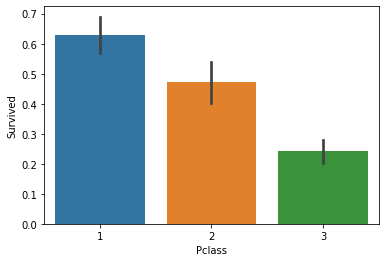

In [20]:
#train_data.groupby('Pclass').Survived.mean().plot(kind='bar')
sns.barplot(x='Pclass', y='Survived', data=train_data)

## Sex vs. Survival
Females have better survival chance.

In [21]:
train_data.Sex.value_counts()



male      577
female    314
Name: Sex, dtype: int64

In [22]:
train_data.groupby('Sex').Survived.value_counts()



Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

In [23]:
train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


<AxesSubplot:xlabel='Sex', ylabel='Survived'>

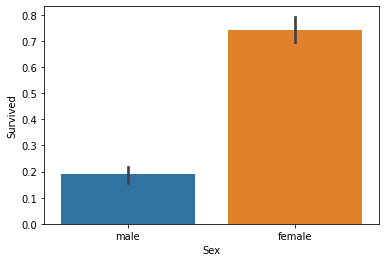

In [24]:
#train_data.groupby('Sex').Survived.mean().plot(kind='bar')
sns.barplot(x='Sex', y='Survived', data=train_data)

## Pclass & Sex vs. Survival¶
Below, we just find out how many males and females are there in each Pclass. We then plot a stacked bar diagram with that information. We found that there are more males among the 3rd Pclass passengers.




Sex     female  male
Pclass              
1           94   122
2           76   108
3          144   347


Text(0, 0.5, 'Percentage')

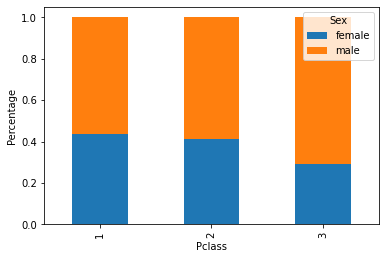

In [25]:
tab = pd.crosstab(train_data['Pclass'], train_data['Sex'])
print (tab)

tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('Pclass')
plt.ylabel('Percentage')

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


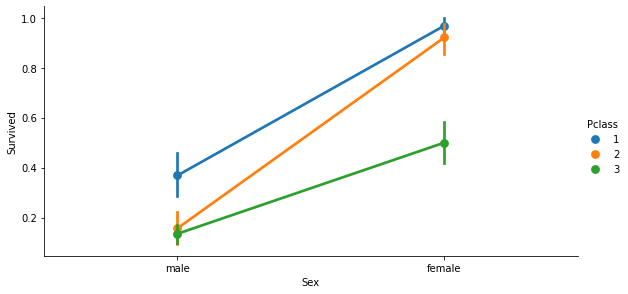

In [26]:
sns.factorplot('Sex', 'Survived', hue='Pclass', size=4, aspect=2, data=train_data)


From the above plot, it can be seen that:

Women from 1st and 2nd Pclass have almost 100% survival chance.
Men from 2nd and 3rd Pclass have only around 10% survival chance.

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


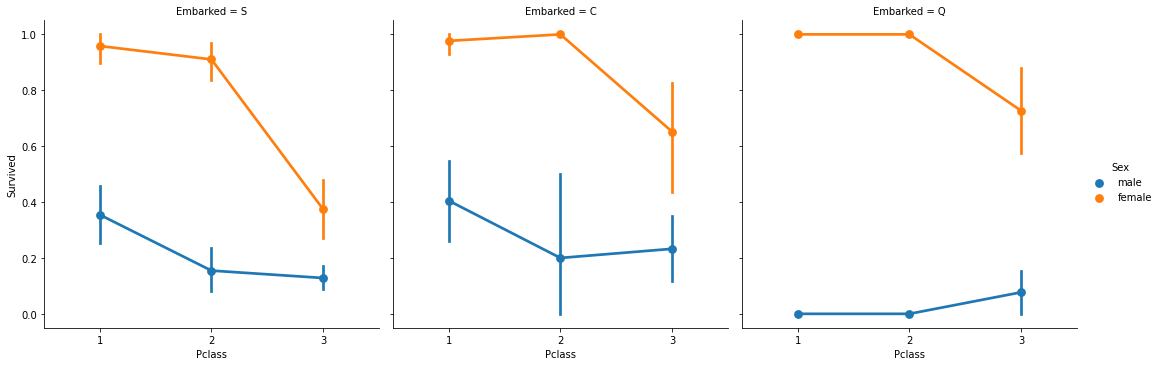

In [27]:
sns.factorplot(x='Pclass', y='Survived', hue='Sex', col='Embarked', data=train_data)


From the above plot, it can be seen that:

Almost all females from Pclass 1 and 2 survived.
Females dying were mostly from 3rd Pclass.
Males from Pclass 1 only have slightly higher survival chance than Pclass 2 and 3.

## Embarked vs. Survived


In [28]:

train_data.Embarked.value_counts()



S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [29]:
train_data.groupby('Embarked').Survived.value_counts()

Embarked  Survived
C         1            93
          0            75
Q         0            47
          1            30
S         0           427
          1           217
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

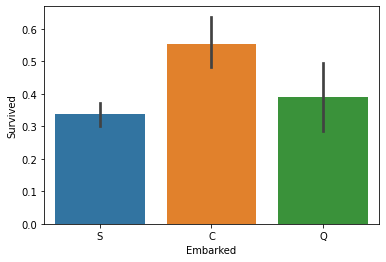

In [30]:
#train_data.groupby('Embarked').Survived.mean().plot(kind='bar')
sns.barplot(x='Embarked', y='Survived', data=train_data)

## Parch vs. Survival



In [31]:
train_data.Parch.value_counts()




0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

In [32]:
train_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


<AxesSubplot:xlabel='Parch', ylabel='Survived'>

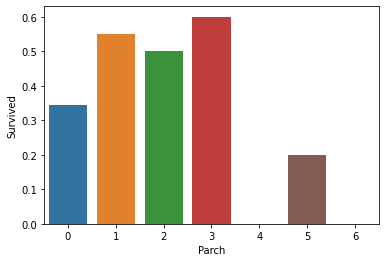

In [33]:
#train_data.groupby('Parch').Survived.mean().plot(kind='bar')
sns.barplot(x='Parch', y='Survived', ci=None, data=train_data) # ci=None will hide the error bar

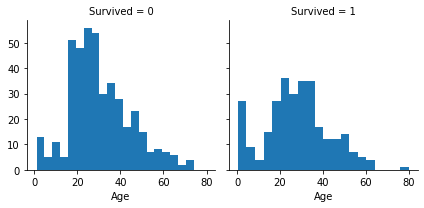

In [34]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


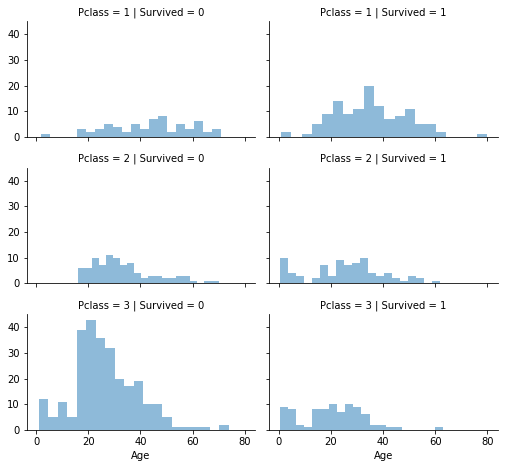

In [35]:
#grid = sns.FacetGrid(train_data, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


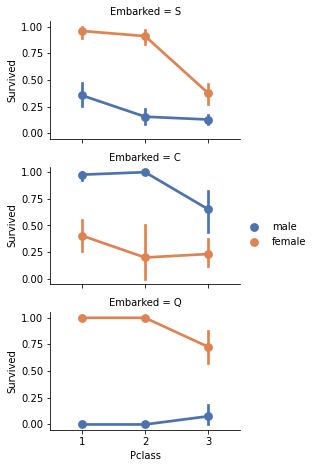

In [36]:
# grid = sns.FacetGrid(train_data, col='Embarked')
grid = sns.FacetGrid(train_data, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

In [37]:
train_data = train_data.drop(['Ticket', 'Cabin'], axis=1)
test_data = test_data.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_data, test_data]
print("Before", train_data.shape, test_data.shape, combine[0].shape, combine[1].shape)
"After", train_data.shape, test_data.shape, combine[0].shape, combine[1].shape

Before (891, 10) (418, 9) (891, 10) (418, 9)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

In [38]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_data['Title'], train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [39]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [40]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [41]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,2.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,8.0500,S,1


## Age vs. Survival

<AxesSubplot:xlabel='Sex', ylabel='Age'>

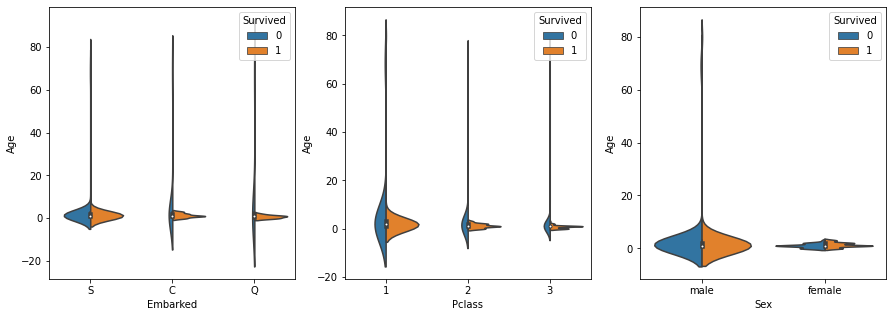

In [42]:


fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.violinplot(x="Embarked", y="Age", hue="Survived", data=train_data, split=True, ax=ax1)
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=train_data, split=True, ax=ax2)
sns.violinplot(x="Sex", y="Age", hue="Survived", data=train_data, split=True, ax=ax3)


From Pclass violinplot, we can see that:

1st Pclass has very few children as compared to other two classes.
1st Plcass has more old people as compared to other two classes.
Almost all children (between age 0 to 10) of 2nd Pclass survived.
Most children of 3rd Pclass survived.
Younger people of 1st Pclass survived as compared to its older people.
From Sex violinplot, we can see that:

Most male children (between age 0 to 14) survived.
Females with age between 18 to 40 have better survival chance


## Correlating Features
Heatmap of Correlation between different features:

Positive numbers = Positive correlation, i.e. increase in one feature will increase the other feature & vice-versa.

Negative numbers = Negative correlation, i.e. increase in one feature will decrease the other feature & vice-versa.

In our case, we focus on which features have strong positive or negative correlation with the Survived feature.




<AxesSubplot:>

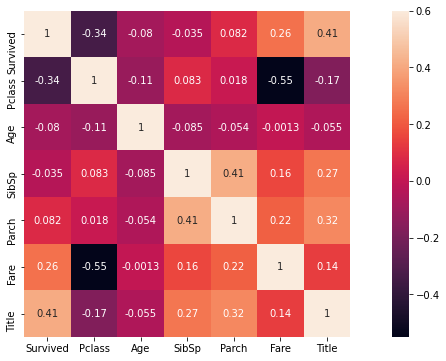

In [43]:
plt.figure(figsize=(15,6))
sns.heatmap(train_data.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)

## Predictions 

Model, predict and solve
Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few.

In [44]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 10), (891,), (418, 9))

In [45]:
#Classification & Accuracy
#Define training and testing set
X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']
X_test = test_data.drop("PassengerId", axis=1).copy()

X_train.shape, y_train.shape, X_test.shape

((891, 10), (891,), (418, 9))

There are many classifying algorithms present. Among them, we choose the following Classification algorithms for our problem:

Logistic Regression
Support Vector Machines (SVC)
Linear SVC
k-Nearest Neighbor (KNN)
Decision Tree
Random Forest
Naive Bayes (GaussianNB)
Perceptron
Stochastic Gradient Descent (SGD)

## Conclusion 
Let's Give It a Try
When you upload the submission CSV file, you should see your score immediately, and that would be around the 0.7940 range, putting you within the top 800. I'm pretty sure you are seeing a lot of room for improvement. For example, I just used averages for filling missing values in Fare but perhaps you can do better than that given the importance of the feature. Maybe you can come up with better engineered features from the variables I glossed over.

